In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import random as rnd

from scipy.sparse import *

from matplotlib import pyplot

In [ ]:
urm_path = '../content/data_train.csv'
urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [ ]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [ ]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [ ]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


# Remove empty profiles

In [ ]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [ ]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [ ]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [ ]:
urm_all = urm_all.tocsr()
urm_all

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

Define the k data partitions for k-folds cross-validation

In [ ]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 5

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


In [ ]:
data_folds

[{'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
  	with 382984 stored elements in Compressed Sparse Row format>,
  'val': <12638x22217 sparse matrix of type '<class 'numpy.float64'>'
  	with 95746 stored elements in Compressed Sparse Row format>},
 {'train': <12638x22221 sparse matrix of type '<class 'numpy.float64'>'
  	with 382984 stored elements in Compressed Sparse Row format>,
  'val': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
  	with 95746 stored elements in Compressed Sparse Row format>},
 {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
  	with 382984 stored elements in Compressed Sparse Row format>,
  'val': <12638x22218 sparse matrix of type '<class 'numpy.float64'>'
  	with 95746 stored elements in Compressed Sparse Row format>},
 {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
  	with 382984 stored elements in Compressed Sparse Row format>,
  'val': <12638x22220 sparse matrix of type '<c

**Fix and save folds of data**

In [ ]:
data_folds[0]['train']

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>

In [ ]:
from scipy.sparse import save_npz, load_npz


for k,fold in enumerate(data_folds):
      print(f'Fold {k} train saving')
      save_npz(f"/content/drive/MyDrive/RecSys/5-fold CV folds/train_noemptyprofiles_fold{k}.npz", fold['train'])
      print(f'Fold {k} val saving')
      save_npz(f"/content/drive/MyDrive/RecSys/5-fold CV folds/val_noemptyprofiles_fold{k}.npz", fold['val'])

Fold 0 train saving
Fold 0 val saving
Fold 1 train saving
Fold 1 val saving
Fold 2 train saving
Fold 2 val saving
Fold 3 train saving
Fold 3 val saving
Fold 4 train saving
Fold 4 val saving


**Check if the saved folds are the same after loading**

In [ ]:
for k,fold in enumerate(data_folds):
      print(f'Fold {k}')
      print(np.array_equal(load_npz(f"/content/train_noemptyprofiles_fold{k}.npz").indices,data_folds[0]['train'].indices))
      print(np.array_equal(load_npz(f"/content/val_noemptyprofiles_fold{k}.npz").indices,data_folds[0]['val'].indices))

      print(np.array_equal(fold['train'].indices,data_folds[1]['train'].indices))
      print(np.array_equal(fold['val'].indices,data_folds[1]['val'].indices))


      print(np.array_equal(fold['train'].indices,data_folds[2]['train'].indices))
      print(np.array_equal(fold['val'].indices,data_folds[2]['val'].indices))


      print(np.array_equal(fold['train'].indices,data_folds[3]['train'].indices))
      print(np.array_equal(fold['val'].indices,data_folds[3]['val'].indices))


      print(np.array_equal(fold['train'].indices,data_folds[4]['train'].indices))
      print(np.array_equal(fold['val'].indices,data_folds[4]['val'].indices))


Fold 0
True
True
False
False
False
False
False
False
False
False
Fold 1
False
False
True
True
False
False
False
False
False
False
Fold 2
False
False
False
False
True
True
False
False
False
False
Fold 3
False
False
False
False
False
False
True
True
False
False
Fold 4
False
False
False
False
False
False
False
False
True
True


# K-fold Cross-Validatoin of hybrids


**Load the similarity matrices of models trained on different train folds**

In [ ]:
from scipy.sparse import save_npz, load_npz

In [ ]:
# SLIM elasticnet

S_slim_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold0_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold1_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold2_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold3_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

S_slim_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /SLIMelasticnet/ItItSimilarity_trained_fold4_noemptyprofiles_SLIMelasticnet_kaggleMAP0.13484.npz')

In [ ]:
S_slim_fold0.indices.shape

(2240133,)

In [ ]:
S_slim_fold0.data.shape

(2240133,)

In [ ]:
# IBCF

S_ibcf_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold0_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold1_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold2_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold3_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

S_ibcf_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold4_noemptyprofiles_IBCF_kaggleMAP0.11585.npz')

In [ ]:
S_ibcf_fold0.indices.shape

(308988,)

In [ ]:
S_ibcf_fold0.data.shape

(308988,)

In [ ]:
# RP3Beta

S_rp3beta_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold0_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold1_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold2_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold3_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

S_rp3beta_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /RP3Beta/ItItSimilarity_trained_fold4_noemptyprofiles_RP3Beta_kaggleMAP0.09372.npz')

In [ ]:
S_rp3beta_fold0.indices.shape

(3527025,)

In [ ]:
S_rp3beta_fold0.data.shape

(3527025,)

In [ ]:
# EASER

S_easer_fold0 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold0_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold1 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold1_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold2 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold2_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold3 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold3_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

S_easer_fold4 = load_npz('/content/drive/MyDrive/RecSys/5-fold CV /EASER/ItItSimilarity_trained_fold4_noemptyprofiles_EASER_kaggleMAP0.12504.npz')

In [ ]:
S_easer_fold0.indices.shape

(5016019,)

In [ ]:
S_easer_fold0.data.shape

(5016019,)

In [ ]:
S_models_fold0 = {
    "SLIM":S_slim_fold0, "IBCF":S_ibcf_fold0,"rp3beta":S_rp3beta_fold0,"EASER":S_easer_fold0
}

S_models_fold1 = {
    "SLIM":S_slim_fold1, "IBCF":S_ibcf_fold1,"rp3beta":S_rp3beta_fold1,"EASER":S_easer_fold1
}

S_models_fold2 = {
    "SLIM":S_slim_fold2, "IBCF":S_ibcf_fold2,"rp3beta":S_rp3beta_fold2,"EASER":S_easer_fold2
}

S_models_fold3 = {
    "SLIM":S_slim_fold3, "IBCF":S_ibcf_fold3,"rp3beta":S_rp3beta_fold3,"EASER":S_easer_fold3
}

S_models_fold4 = {
    "SLIM":S_slim_fold4, "IBCF":S_ibcf_fold4,"rp3beta":S_rp3beta_fold4,"EASER":S_easer_fold4
}

fold_models = [S_models_fold0,S_models_fold1,S_models_fold2,S_models_fold3,S_models_fold4]

**Examine similarity distributions**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

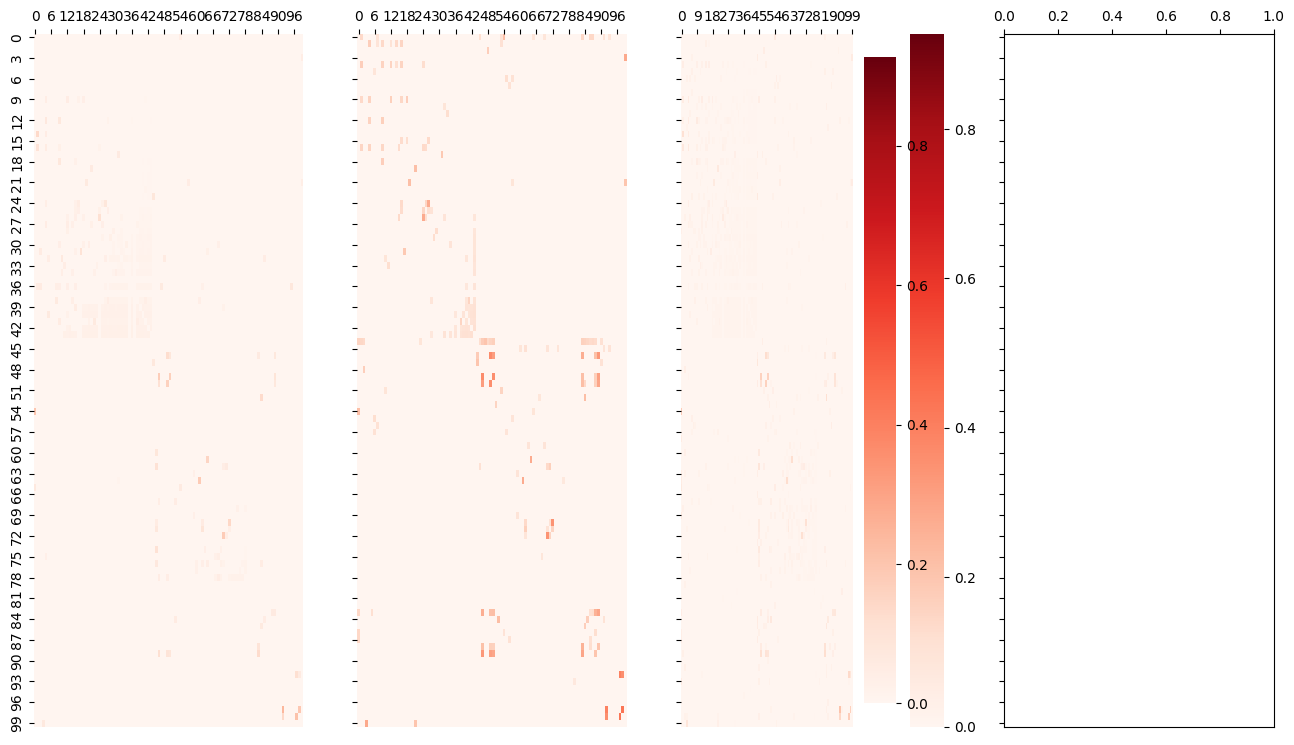

In [ ]:
slim_sim_max = S_slim_fold0.max()
ibcf_sim_max = S_ibcf_fold0.max()
rp3beta_sim_max = S_rp3beta_fold0.max()
easer_sim_max = S_easer_fold0.max()
vmax = np.max([slim_sim_max, ibcf_sim_max, rp3beta_sim_max,easer_sim_max])


f, [ax1, ax2, ax3,ax4] = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
sns.heatmap(S_slim_fold0[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds")
sns.heatmap(S_ibcf_fold0[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds")
sns.heatmap(S_rp3beta_fold0[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds")
sns.heatmap(S_easer_fold0[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds")
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")
ax4.xaxis.set_ticks_position("top")

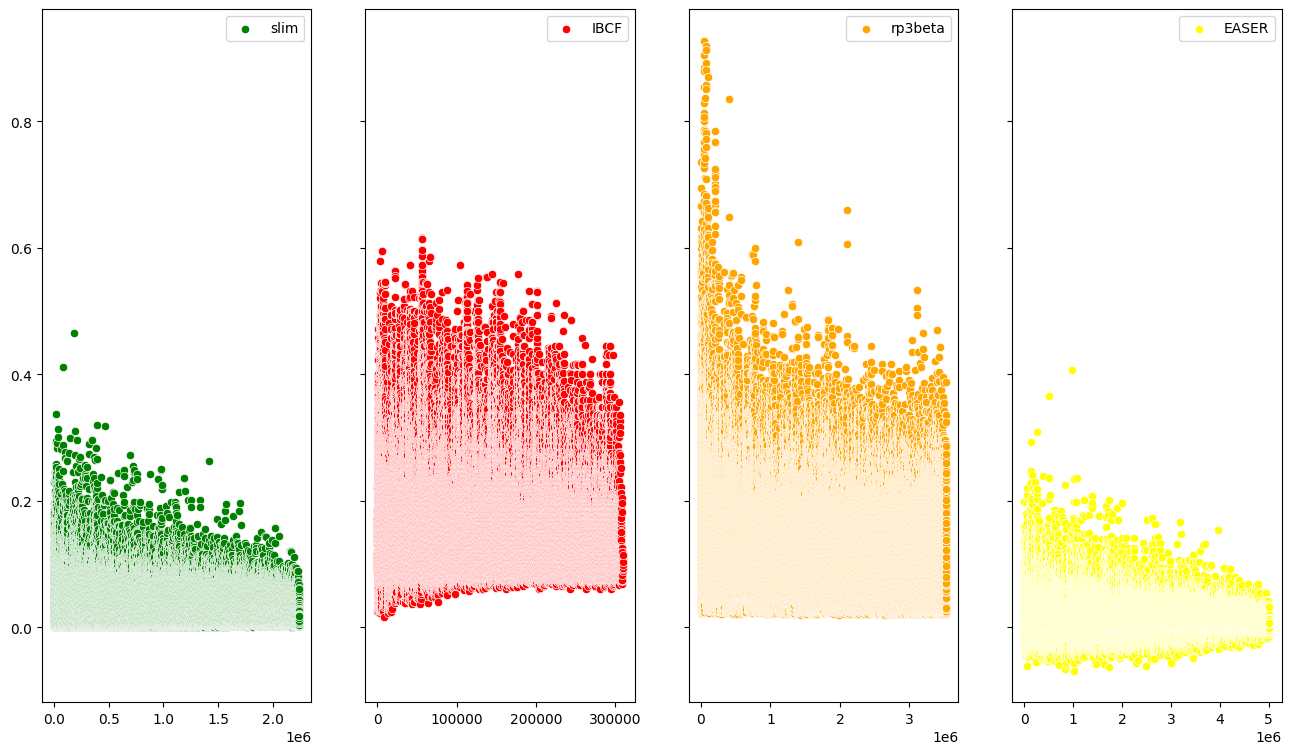

In [ ]:
f, [ax1, ax2, ax3,ax4] = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
sns.scatterplot(data=S_slim_fold0.data, ax=ax1, color="green")
sns.scatterplot(data=S_ibcf_fold0.data, ax=ax2, color="red")
sns.scatterplot(data=S_rp3beta_fold0.data, ax=ax3, color="orange")
sns.scatterplot(data=S_easer_fold0.data, ax=ax4, color="yellow")
ax1.legend(["slim"])
ax2.legend(["IBCF"])
ax3.legend(["rp3beta"])
ax4.legend(["EASER"])

**Normalise the similarity values**

In [ ]:
from numpy import linalg as LA

In [ ]:
l1_slim_fold0 = LA.norm(S_slim_fold0.data, 1)
l1_slim_fold0_similarities = S_slim_fold0.data / l1_slim_fold0

l1_ibcf_fold0 = LA.norm(S_ibcf_fold0.data, 1)
l1_ibcf_fold0_similarities = S_ibcf_fold0.data / l1_ibcf_fold0

l1_rp3beta_fold0 = LA.norm(S_rp3beta_fold0.data, 1)
l1_l1_rp3beta_fold0_similarities = S_rp3beta_fold0.data / l1_rp3beta_fold0

l1_easer_fold0 = LA.norm(S_easer_fold0.data, 1)
l1_easer_fold0_similarities = S_easer_fold0.data / l1_easer_fold0

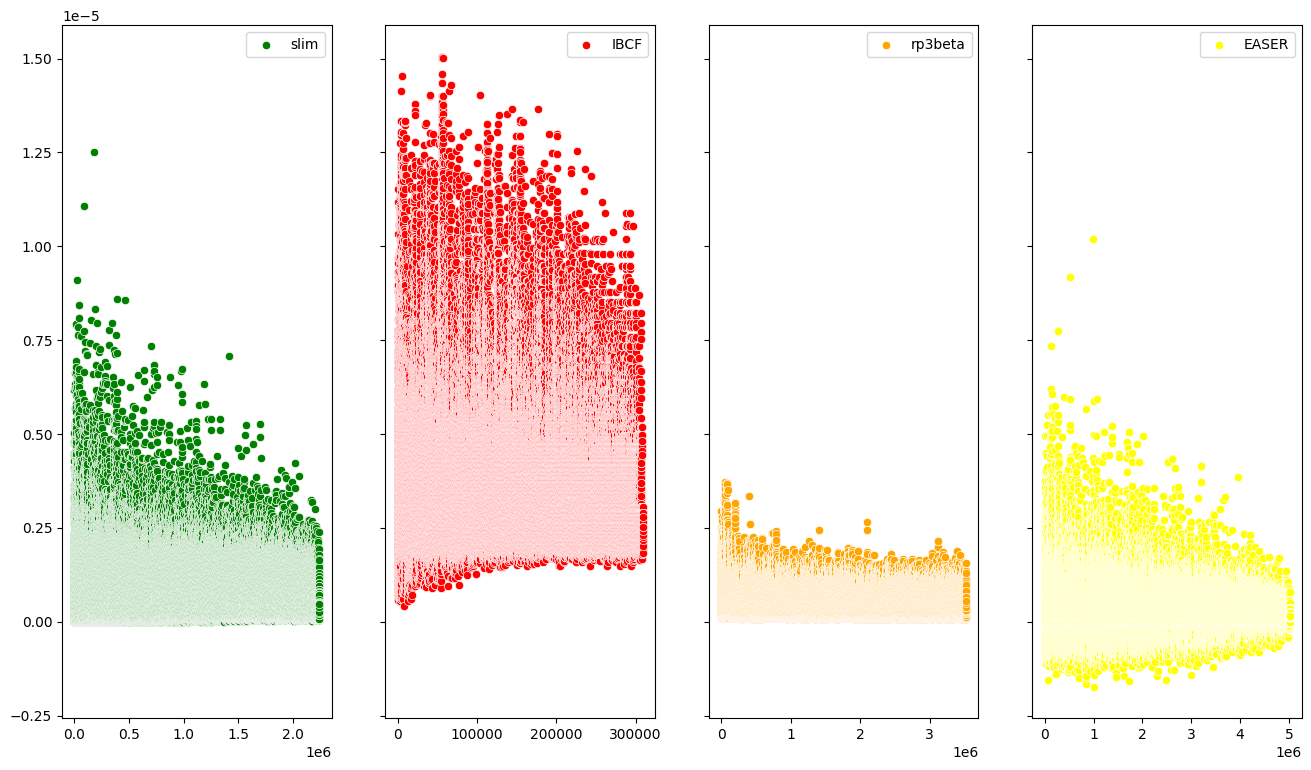

In [ ]:
f, [ax1, ax2, ax3,ax4] = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
sns.scatterplot(data=l1_slim_fold0_similarities, ax=ax1, color="green")
sns.scatterplot(data=l1_ibcf_fold0_similarities, ax=ax2, color="red")
sns.scatterplot(data=l1_l1_rp3beta_fold0_similarities, ax=ax3, color="orange")
sns.scatterplot(data=l1_easer_fold0_similarities, ax=ax4, color="yellow")
ax1.legend(["slim"])
ax2.legend(["IBCF"])
ax3.legend(["rp3beta"])
ax4.legend(["EASER"])

**Normalise the similarity matrices with L1 normalisation**

In [ ]:
def normalise_l1_similarities(model_similarities):
  l1_model = LA.norm(model_similarities, 1)
  l1_model_similarities = model_similarities / l1_model
  return l1_model_similarities

S_slim_fold0_l1 = S_slim_fold0.copy()
S_slim_fold0_l1.data = normalise_l1_similarities(S_slim_fold0_l1.data)

S_slim_fold1_l1 = S_slim_fold1.copy()
S_slim_fold1_l1.data = normalise_l1_similarities(S_slim_fold1_l1.data)

S_slim_fold2_l1 = S_slim_fold2.copy()
S_slim_fold2_l1.data = normalise_l1_similarities(S_slim_fold2_l1.data)

S_slim_fold3_l1 = S_slim_fold3.copy()
S_slim_fold3_l1.data = normalise_l1_similarities(S_slim_fold3_l1.data)

S_slim_fold4_l1 = S_slim_fold4.copy()
S_slim_fold4_l1.data = normalise_l1_similarities(S_slim_fold4_l1.data)

S_ibcf_fold0_l1 = S_ibcf_fold0.copy()
S_ibcf_fold0_l1.data = normalise_l1_similarities(S_ibcf_fold0_l1.data)

S_ibcf_fold1_l1 = S_ibcf_fold1.copy()
S_ibcf_fold1_l1.data = normalise_l1_similarities(S_ibcf_fold1_l1.data)

S_ibcf_fold2_l1 = S_ibcf_fold2.copy()
S_ibcf_fold2_l1.data = normalise_l1_similarities(S_ibcf_fold2_l1.data)

S_ibcf_fold3_l1 = S_ibcf_fold3.copy()
S_ibcf_fold3_l1.data = normalise_l1_similarities(S_ibcf_fold3_l1.data)

S_ibcf_fold4_l1 = S_ibcf_fold4.copy()
S_ibcf_fold4_l1.data = normalise_l1_similarities(S_ibcf_fold4_l1.data)


S_rp3beta_fold0_l1 = S_rp3beta_fold0.copy()
S_rp3beta_fold0_l1.data = normalise_l1_similarities(S_rp3beta_fold0_l1.data)

S_rp3beta_fold1_l1 = S_rp3beta_fold1.copy()
S_rp3beta_fold1_l1.data = normalise_l1_similarities(S_rp3beta_fold1_l1.data)

S_rp3beta_fold2_l1 = S_rp3beta_fold2.copy()
S_rp3beta_fold2_l1.data = normalise_l1_similarities(S_rp3beta_fold2_l1.data)

S_rp3beta_fold3_l1 = S_rp3beta_fold3.copy()
S_rp3beta_fold3_l1.data = normalise_l1_similarities(S_rp3beta_fold3_l1.data)

S_rp3beta_fold4_l1 = S_rp3beta_fold4.copy()
S_rp3beta_fold4_l1.data = normalise_l1_similarities(S_rp3beta_fold4_l1.data)


S_easer_fold0_l1 = S_easer_fold0.copy()
S_easer_fold0_l1.data = normalise_l1_similarities(S_easer_fold0_l1.data)

S_easer_fold1_l1 = S_easer_fold1.copy()
S_easer_fold1_l1.data = normalise_l1_similarities(S_easer_fold1_l1.data)

S_easer_fold2_l1 = S_easer_fold2.copy()
S_easer_fold2_l1.data = normalise_l1_similarities(S_easer_fold2_l1.data)

S_easer_fold3_l1 = S_easer_fold3.copy()
S_easer_fold3_l1.data = normalise_l1_similarities(S_easer_fold3_l1.data)

S_easer_fold4_l1 = S_easer_fold4.copy()
S_easer_fold4_l1.data = normalise_l1_similarities(S_easer_fold4_l1.data)

In [ ]:
S_models_l1_fold0 = {
    "SLIM":S_slim_fold0_l1, "IBCF":S_ibcf_fold0_l1,"rp3beta":S_rp3beta_fold0_l1,"EASER":S_easer_fold0_l1
}

S_models_l1_fold1 = {
    "SLIM":S_slim_fold1_l1, "IBCF":S_ibcf_fold1_l1,"rp3beta":S_rp3beta_fold1_l1,"EASER":S_easer_fold1_l1
}

S_models_l1_fold2 = {
    "SLIM":S_slim_fold2_l1, "IBCF":S_ibcf_fold2_l1,"rp3beta":S_rp3beta_fold2_l1,"EASER":S_easer_fold2_l1
}

S_models_l1_fold3 = {
    "SLIM":S_slim_fold3_l1, "IBCF":S_ibcf_fold3_l1,"rp3beta":S_rp3beta_fold3_l1,"EASER":S_easer_fold3_l1
}

S_models_l1_fold4 = {
    "SLIM":S_slim_fold4_l1, "IBCF":S_ibcf_fold4_l1,"rp3beta":S_rp3beta_fold4_l1,"EASER":S_easer_fold4_l1
}

fold_l1_models = [S_models_l1_fold0,S_models_l1_fold1,S_models_l1_fold2,S_models_l1_fold3,S_models_l1_fold4]



**Utils for hybrid evaluation**

In [ ]:
!unzip /content/Recommenders.zip
!unzip /content/Utils.zip

In [ ]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

In [ ]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at,exclude_seen=True)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.10f}, Recall = {:.10f}, MAP = {:.10f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

In [ ]:
class Predictor(object):

    def __init__(self, URM, model):
        self.URM = URM
        self.model = model

    def recommend(self, user_id, at=10, exclude_seen=True):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # compute the scores using the fitted model
        scores = self.model._compute_item_score(user_id)[0]

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

**Evaluate with 5-fold CV the perfomance of our best model - SLIM elasticnet standalone**

In [ ]:
import gc

In [ ]:
data_folds = []

for fold_n in range(5):
  fold_urm_train = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/train_noemptyprofiles_fold{fold_n}.npz')
  fold_urm_val = load_npz(f'/content/drive/MyDrive/RecSys/5-fold CV /Folds/val_noemptyprofiles_fold{fold_n}.npz')
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})

print(data_folds)

[{'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22217 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22221 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22218 sparse matrix of type '<class 'numpy.float64'>'
	with 95746 stored elements in Compressed Sparse Row format>}, {'train': <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 382984 stored elements in Compressed Sparse Row format>, 'val': <12638x22220 sparse matrix of type '<class 'numpy.float64'>'
	w

In [ ]:
# Evaluate our best SLIM elasticnet with 5-fold CV
alpha = 1

folds_map = []
for k,fold in enumerate(data_folds):
  print(f'Fold {k} evaluations started')

  S_slim_elastic = fold_l1_models[k]["SLIM"]
  S_IBCF = fold_l1_models[k]["IBCF"]
  new_similarity = (1 - alpha) * S_IBCF  + alpha * S_slim_elastic
  recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  recommender_object.fit(new_similarity)
  recommender = Predictor(URM=fold['train'], model = recommender_object)

  map, mp,mr = evaluate_algorithm(fold['val'],recommender)
  folds_map.append(map)

  # Delete the recommender object to save memory
  del recommender
  gc.collect()

cv_map = np.array(folds_map).sum()/len(data_folds)
print(f'The crossvalidation MAP is {cv_map}')

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 987.9000000001, Recall = 1373.5474415512, MAP = 0.0828034589
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 990.2000000000, Recall = 1385.4382268197, MAP = 0.0825376427
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 976.6000000001, Recall = 1347.8322337381, MAP = 0.0812761219
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

**Evaluate with 5-fold CV the perfomance of our best hybrid: NON-NORMALISED matrix merge SLIM elasticnet with IBCF**

In [ ]:
# Evaluate our best hybrid submission i.e. 0.88*SLIM elasticnet + 0.12*IBCF with 5-fold CV
# NON-NORMALISED SIMILARITIES
alpha = 0.88

folds_map = []
for k,fold in enumerate(data_folds):
  print(f'Fold {k} evaluations started')

  S_slim_elastic = fold_models[k]["SLIM"]
  S_IBCF = fold_models[k]["IBCF"]
  new_similarity = (1 - alpha) * S_IBCF  + alpha * S_slim_elastic

  recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
  recommender_object.fit(new_similarity)
  recommender = Predictor(URM=fold['train'], model = recommender_object)

  map, mp,mr = evaluate_algorithm(fold['val'],recommender)
  folds_map.append(map)

  # Delete the recommender object to save memory
  del recommender
  gc.collect()

cv_map = np.array(folds_map).sum()/len(data_folds)
print(f'The crossvalidation MAP is {cv_map}')

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1011.2000000001, Recall = 1436.5382722233, MAP = 0.0851461648
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1018.7000000001, Recall = 1457.8344762451, MAP = 0.0848002873
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1001.1000000001, Recall = 1413.8965932578, MAP = 0.0831666147
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) 

**Search for best alpha for NORMALISED matrix merge for SLIM elastic and IBCF**

In [ ]:
from scipy.stats import loguniform
from scipy.stats import uniform

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.001,0.99, size=10).astype(float))))

print(f"Alpha:{rnd_alpha}")

In [ ]:
# Evaluate hybrid of SLIM and IBCF with 5-fold CV


hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_l1_models[k]["SLIM"]# NORMALISED SIMILARITIES
      S_IBCF = fold_l1_models[k]["IBCF"]# NORMALISED SIMILARITIES
      new_similarity = (1 - alpha) * S_IBCF  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 914.6000000001, Recall = 1316.5799491329, MAP = 0.0749147264
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 903.9000000000, Recall = 1298.0299929796, MAP = 0.0744766081
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 895.5000000001, Recall = 1290.1507971079, MAP = 0.0738603539
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

      alpha       MAP
4  0.052686  0.075158
7  0.122164   0.07581
2  0.194643  0.076671
9  0.200200  0.076713
8  0.214009  0.076845
0  0.228924  0.077041
6  0.609847  0.082151
1  0.614236  0.082258
5  0.948327  0.084365
3  0.973141  0.083834


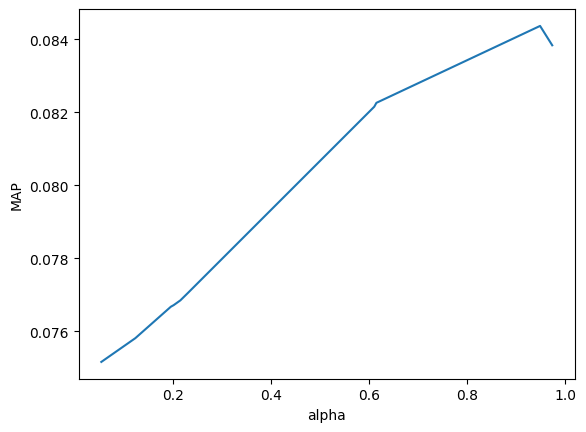

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.948327
MAP      0.084365
Name: 5, dtype: object

**Try NON-NORMALISED similarity matrices for hybrid SLIMelastic and IBCF**

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.10,0.89, size=30).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.22350182 0.42429184 0.69089087 0.25850451 0.38562069 0.11107783
 0.14101973 0.44453796 0.29324162 0.7899724  0.46425353 0.10455829
 0.85782085 0.79847359 0.35035449 0.8842067  0.20771811 0.35577868
 0.36722936 0.76557121 0.22517268 0.92664288 0.4543689  0.53103381
 0.61075944 0.63189621 0.66958395 0.43473064 0.69513016 0.80911493]


In [ ]:
# Evaluate hybrid of SLIM and IBCF with 5-fold CV
# NON-NORMALISED SIMILARITIES

hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_IBCF = fold_models[k]["IBCF"]
      new_similarity = (1 - alpha) * S_IBCF  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 916.6000000001, Recall = 1321.3450478342, MAP = 0.0753376343
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 909.0000000000, Recall = 1304.0460687019, MAP = 0.0749528893
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 899.6000000001, Recall = 1293.9126624467, MAP = 0.0742672527
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

       alpha       MAP
11  0.104558  0.075561
5   0.111078  0.075621
6   0.141020  0.075898
16  0.207718  0.076649
0   0.223502  0.076779
20  0.225173  0.076786
3   0.258505  0.077152
8   0.293242  0.077582
14  0.350354  0.078181
17  0.355779  0.078267
18  0.367229  0.078367
4   0.385621  0.078666
1   0.424292  0.079225
27  0.434731  0.079369
7   0.444538  0.079466
22  0.454369  0.079613
10  0.464254  0.079745
23  0.531034  0.080666
24  0.610759  0.081858
25  0.631896  0.082146
26  0.669584  0.082729
2   0.690891  0.083058
28  0.695130  0.083089
19  0.765571  0.084013
9   0.789972  0.084261
13  0.798474  0.084352
29  0.809115  0.084424
12  0.857821  0.084903
15  0.884207  0.085008
21  0.926643  0.084623


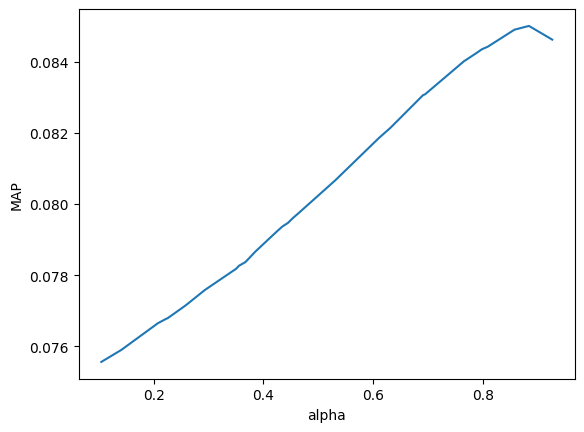

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.884207
MAP      0.085008
Name: 15, dtype: object

**Search for best alpha for NORMALISED matrix merge for SLIM elastic and EASER**

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.001,0.99, size=10).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.80066774 0.66457195 0.15287954 0.23184258 0.86092471 0.32826794
 0.98493628 0.87306272 0.11649807 0.26452661]


In [ ]:
# Evaluate hybrid of SLIM and EASER with 5-fold CV


hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_l1_models[k]["SLIM"]# NORMALISED SIMILARITIES
      S_easer = fold_l1_models[k]["EASER"]# NORMALISED SIMILARITIES
      new_similarity = (1 - alpha) * S_easer  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 977.9000000001, Recall = 1438.7105925010, MAP = 0.0818394245
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 981.0000000001, Recall = 1444.9754257394, MAP = 0.0816406673
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 957.9000000001, Recall = 1392.3666246485, MAP = 0.0798626769
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

      alpha       MAP
8  0.116498  0.081911
2  0.152880  0.082329
3  0.231843  0.082946
9  0.264527  0.083113
5  0.328268    0.0835
1  0.664572  0.084017
0  0.800668  0.083781
4  0.860925  0.083591
7  0.873063  0.083543
6  0.984936  0.083008


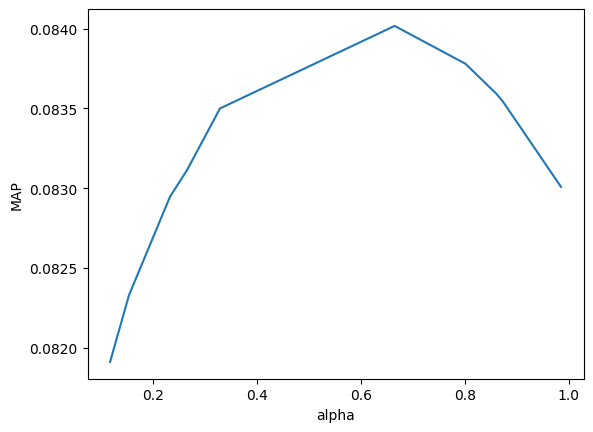

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.664572
MAP      0.084017
Name: 1, dtype: object

In [ ]:
# More narrow alpha range

rnd_alpha = np.array(list(set(uniform.rvs(0.6,0.2, size=5).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.71667367 0.7889422  0.61332083 0.73132902 0.65253329]


In [ ]:
# Evaluate hybrid of SLIM and EASER with 5-fold CV with more narrow alpha range


hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_l1_models[k]["SLIM"]# NORMALISED SIMILARITIES
      S_easer = fold_l1_models[k]["EASER"]# NORMALISED SIMILARITIES
      new_similarity = (1 - alpha) * S_easer  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 999.2000000001, Recall = 1421.8568275498, MAP = 0.0836810494
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1005.9000000001, Recall = 1436.8709499914, MAP = 0.0839553254
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 987.0000000001, Recall = 1400.3416241482, MAP = 0.0821958886
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) us

      alpha       MAP
2  0.613321  0.084018
4  0.652533  0.083995
0  0.716674  0.083878
3  0.731329  0.083885
1  0.788942    0.0838


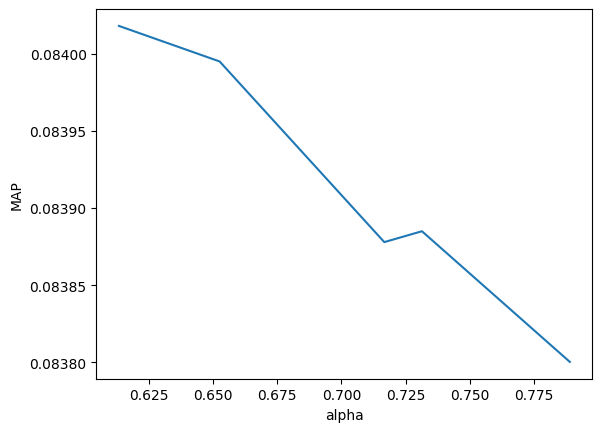

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.613321
MAP      0.084018
Name: 2, dtype: object

**Try NON-NORMALISED similarity matrices for hybrid SLIMelastic and EASER**

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.05,0.84, size=30).astype(float))))

print(f"Alpha:{rnd_alpha}")

In [ ]:
# Evaluate hybrid of SLIM and EASER with 5-fold CV
# NON-NORMALISED SIMILARITIES

hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_easer = fold_models[k]["EASER"]
      new_similarity = (1 - alpha) * S_easer  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 967.1000000001, Recall = 1434.1026580124, MAP = 0.0811752565
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 969.3000000001, Recall = 1433.9732587111, MAP = 0.0808505732
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 950.4000000001, Recall = 1390.1061019831, MAP = 0.0791743645
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

       alpha       MAP
15  0.055677  0.081203
25  0.075848  0.081409
23  0.114069  0.081795
24  0.120686  0.081877
10  0.150969  0.082209
9   0.189087  0.082513
12  0.224936  0.082754
22  0.264229  0.083023
2   0.266666  0.083042
28  0.290213  0.083194
19  0.326347  0.083398
27  0.409821  0.083652
29  0.425540  0.083727
1   0.464518  0.083846
16  0.515723  0.083995
5   0.584651  0.084062
20  0.604705  0.084088
18  0.606365  0.084089
11  0.607771  0.084086
21  0.633946  0.084047
13  0.660488  0.084002
3   0.670349     0.084
8   0.708240  0.083907
14  0.760602  0.083865
7   0.764653  0.083869
6   0.774129   0.08387
4   0.790287  0.083806
17  0.823100  0.083747
0   0.824987   0.08373
26  0.839565  0.083672


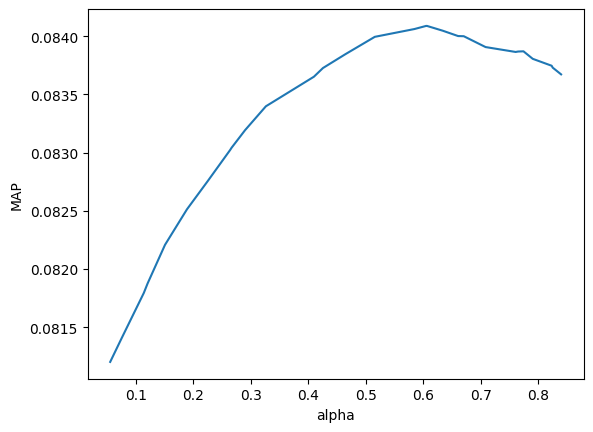

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.606365
MAP      0.084089
Name: 18, dtype: object

**Search for best alpha for NORMALISED matrix merge for SLIM elastic and RP3Beta**

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.001,0.99, size=10).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.12691962 0.61048767 0.11763018 0.02754256 0.77238052 0.8530113
 0.68602386 0.1550503  0.26682065 0.0037017 ]


In [ ]:
# Evaluate hybrid of SLIM and RP3Beta with 5-fold CV


hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_l1_models[k]["SLIM"]# NORMALISED SIMILARITIES
      S_rp3beta = fold_l1_models[k]["rp3beta"]# NORMALISED SIMILARITIES
      new_similarity = (1 - alpha) * S_rp3beta  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 785.8000000000, Recall = 1238.7570125615, MAP = 0.0669426064
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 778.2000000000, Recall = 1191.0377555026, MAP = 0.0648834209
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 780.7000000000, Recall = 1225.4359486068, MAP = 0.0661865457
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

      alpha       MAP
9  0.003702  0.067254
3  0.027543  0.068296
2  0.117630  0.071691
0  0.126920  0.072025
7  0.155050  0.073033
8  0.266821  0.076796
1  0.610488  0.083557
6  0.686024   0.08413
4  0.772381  0.084254
5  0.853011  0.084125


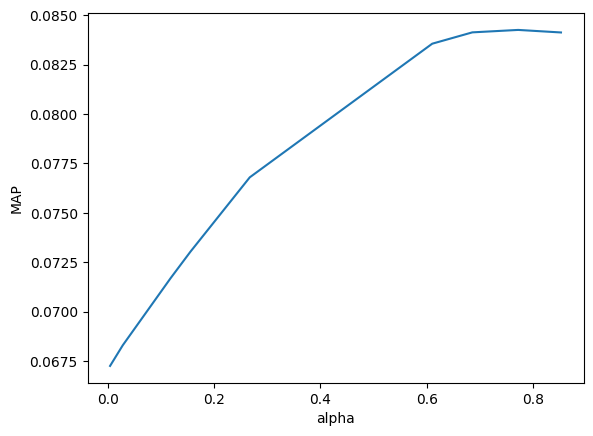

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.772381
MAP      0.084254
Name: 4, dtype: object

In [ ]:
# More narrow alpha range

rnd_alpha = np.array(list(set(uniform.rvs(0.65,0.2, size=5).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.76973424 0.691336   0.79417744 0.75496122 0.8497519 ]


In [ ]:
# Evaluate hybrid of SLIM and RP3Beta with 5-fold CV


hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_l1_models[k]["SLIM"]# NORMALISED SIMILARITIES
      S_rp3beta = fold_l1_models[k]["rp3beta"]# NORMALISED SIMILARITIES
      new_similarity = (1 - alpha) * S_rp3beta  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 997.9000000001, Recall = 1448.7863465636, MAP = 0.0844285321
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1008.7000000001, Recall = 1451.8266570866, MAP = 0.0836910094
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 983.1000000001, Recall = 1416.2399286289, MAP = 0.0823001413
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) us

      alpha       MAP
1  0.691336  0.084113
3  0.754961  0.084245
0  0.769734  0.084244
2  0.794177  0.084295
4  0.849752  0.084151


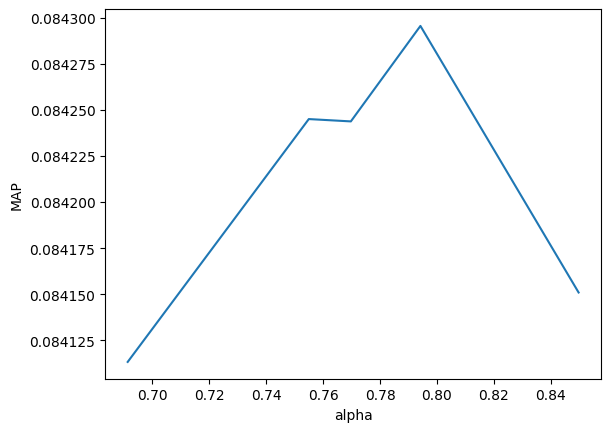

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.794177
MAP      0.084295
Name: 2, dtype: object

**Try NON-NORMALISED similarity matrices for hybrid SLIMelastic and RP3Beta**

In [ ]:
rnd_alpha = np.array(list(set(uniform.rvs(0.03,0.96, size=30).astype(float))))

print(f"Alpha:{rnd_alpha}")

Alpha:[0.58024415 0.7655229  0.48611007 0.33753961 0.72190613 0.68305867
 0.80276953 0.44019245 0.15498941 0.25880553 0.45556378 0.86157087
 0.04366719 0.09507495 0.19021445 0.58258742 0.18470759 0.08795012
 0.16460354 0.18672883 0.84919823 0.07053587 0.47637976 0.94707235
 0.74280171 0.68837694 0.76405773 0.07575917 0.52038139 0.62686101]


In [ ]:
# Evaluate hybrid of SLIM and RP3Beta with 5-fold CV
# NON-NORMALISED SIMILARITIES

hyperparameter_search_rnd = pd.DataFrame(columns = ["alpha", "MAP"])
hyperparameter_search_rnd["alpha"] = rnd_alpha
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="alpha")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      alpha = hyperparameter_search_rnd.loc[index,"alpha"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_rp3beta = fold_models[k]["rp3beta"]
      new_similarity = (1 - alpha) * S_rp3beta  + alpha * S_slim_elastic

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"alpha"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 787.1000000000, Recall = 1240.1380350756, MAP = 0.0669978579
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 779.2000000000, Recall = 1192.5033243176, MAP = 0.0651211417
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 782.6000000000, Recall = 1228.1770932167, MAP = 0.0663951082
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

       alpha       MAP
12  0.043667  0.067405
21  0.070536   0.06765
27  0.075759  0.067718
17  0.087950  0.067813
13  0.095075  0.067852
8   0.154989  0.068264
18  0.164604  0.068352
16  0.184708  0.068502
19  0.186729  0.068509
14  0.190214  0.068546
9   0.258806  0.069103
3   0.337540  0.069989
7   0.440192  0.071272
10  0.455564  0.071498
22  0.476380   0.07176
2   0.486110  0.071931
28  0.520381  0.072479
0   0.580244  0.073575
15  0.582587   0.07364
29  0.626861  0.074603
5   0.683059  0.076033
25  0.688377  0.076193
4   0.721906  0.077131
24  0.742802  0.077815
26  0.764058  0.078455
1   0.765523  0.078507
6   0.802770  0.079817
20  0.849198  0.081344
11  0.861571  0.081739
23  0.947072  0.084235


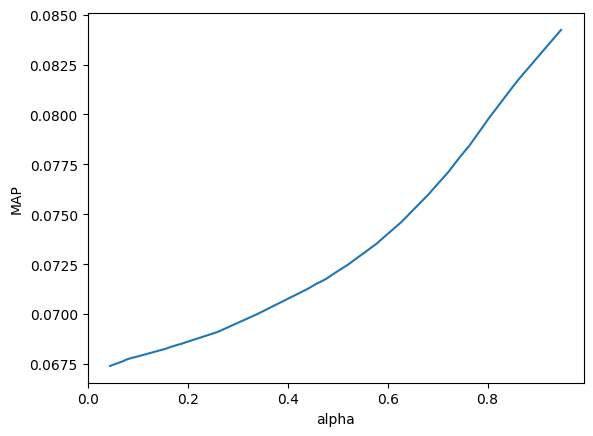

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["alpha"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.show()

In [ ]:
best_alpha_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_alpha_value

alpha    0.947072
MAP      0.084235
Name: 23, dtype: object

**Search for best beta for NON-NORMALISED matrix merge for (0.88*SLIM elastic + 0.12*IBCF) and EASER**

In [ ]:
rnd_beta = np.array(list(set(uniform.rvs(0.01,0.99, size=10).astype(float))))

print(f"Beta:{rnd_beta}")

Beta:[0.79357331 0.98583896 0.16010807 0.4695997  0.40501854 0.23395045
 0.91310698 0.69063156 0.5879996  0.49995278]


In [ ]:
# Evaluate hybrid of our best submission i.e. (0.88*SLIM elasticnet + 0.12*IBCF) and EASER with 5-fold CV
# NON-NORMALISED SIMILARITIES
alpha = 0.88

hyperparameter_search_rnd = pd.DataFrame(columns = ["beta", "MAP"])
hyperparameter_search_rnd["beta"] = rnd_beta
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="beta")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      beta = hyperparameter_search_rnd.loc[index,"beta"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_ibcf = fold_models[k]["IBCF"]
      S_easer = fold_models[k]["EASER"]
      new_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"beta"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 990.1000000001, Recall = 1453.6317255688, MAP = 0.0826220468
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 989.1000000001, Recall = 1455.0363551259, MAP = 0.0825706880
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 973.6000000001, Recall = 1411.2960643835, MAP = 0.0808919370
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

       beta       MAP
2  0.160108  0.082845
5  0.233950   0.08349
4  0.405019  0.084623
3  0.469600  0.084884
9  0.499953  0.085032
8  0.588000  0.085316
7  0.690632  0.085418
0  0.793573  0.085377
6  0.913107  0.085111
1  0.985839  0.085031


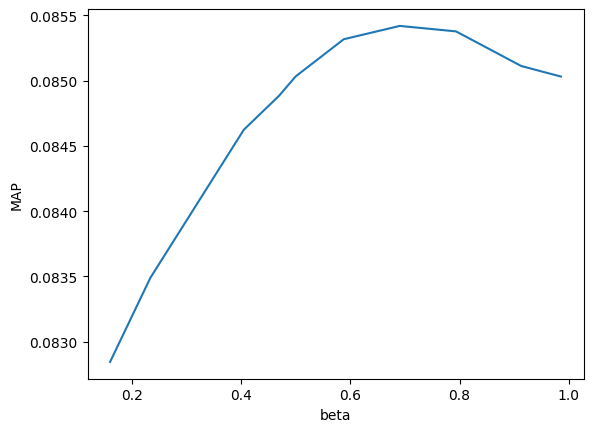

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["beta"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('beta')
pyplot.show()

In [ ]:
best_beta_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_beta_value

beta    0.690632
MAP     0.085418
Name: 7, dtype: object

In [ ]:
# Narrow down the beta range

rnd_beta = np.array(list(set(uniform.rvs(0.55,0.24, size=5).astype(float))))

print(f"Beta:{rnd_beta}")

Beta:[0.78113004 0.56424759 0.73906472 0.6432857  0.68590672]


In [ ]:
# Evaluate hybrid of our best submission i.e. (0.88*SLIM elasticnet + 0.12*IBCF) and EASER with 5-fold CV
# NON-NORMALISED SIMILARITIES
alpha = 0.88

hyperparameter_search_rnd = pd.DataFrame(columns = ["beta", "MAP"])
hyperparameter_search_rnd["beta"] = rnd_beta
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="beta")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      beta = hyperparameter_search_rnd.loc[index,"beta"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_ibcf = fold_models[k]["IBCF"]
      S_easer = fold_models[k]["EASER"]
      new_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_easer

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"beta"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1020.1000000001, Recall = 1470.0799428821, MAP = 0.0855166546
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1020.5000000001, Recall = 1469.0974818830, MAP = 0.0847708653
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 1007.2000000001, Recall = 1430.6946193394, MAP = 0.0833126675
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) 

       beta       MAP
1  0.564248  0.085258
3  0.643286  0.085363
4  0.685907  0.085426
2  0.739065  0.085361
0  0.781130  0.085366


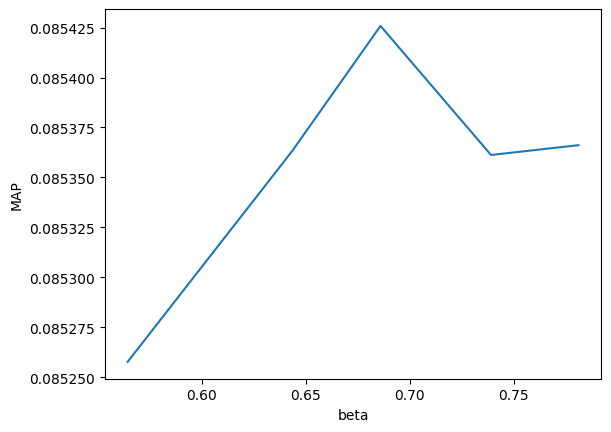

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["beta"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('beta')
pyplot.show()

In [ ]:
best_beta_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_beta_value

beta    0.685907
MAP     0.085426
Name: 4, dtype: object

**Search for best beta for NON-NORMALISED matrix merge for (0.88*SLIM elastic + 0.12*IBCF) and RP3Beta**

In [ ]:
rnd_beta = np.array(list(set(uniform.rvs(0.01,0.99, size=10).astype(float))))

print(f"Beta:{rnd_beta}")

Beta:[0.79357331 0.98583896 0.16010807 0.4695997  0.40501854 0.23395045
 0.91310698 0.69063156 0.5879996  0.49995278]


In [ ]:
# Evaluate hybrid of our best submission i.e. (0.88*SLIM elasticnet + 0.12*IBCF) and RP3Beta with 5-fold CV
# NON-NORMALISED SIMILARITIES
alpha = 0.88

hyperparameter_search_rnd = pd.DataFrame(columns = ["beta", "MAP"])
hyperparameter_search_rnd["beta"] = rnd_beta
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="beta")

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')

      beta = hyperparameter_search_rnd.loc[index,"beta"]
      S_slim_elastic = fold_models[k]["SLIM"]
      S_ibcf = fold_models[k]["IBCF"]
      S_rp3beta = fold_models[k]["rp3beta"]
      new_similarity = beta * ((1 - alpha) * S_ibcf  + alpha * S_slim_elastic) + (1 - beta) * S_rp3beta

      recommender_object = ItemKNNCustomSimilarityRecommender(fold['train'])
      recommender_object.fit(new_similarity)
      recommender = Predictor(URM=fold['train'], model = recommender_object)

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

      # Delete the recommender object to save memory
      del recommender
      gc.collect()

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"beta"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 205 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 120 ( 0.5%) items with no interactions.
Recommender results are: Precision = 796.1000000000, Recall = 1252.6734919145, MAP = 0.0682432052
Fold 1 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 221 ( 1.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.
Recommender results are: Precision = 788.7000000000, Recall = 1204.8178653458, MAP = 0.0661516371
Fold 2 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 196 ( 1.6%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 119 ( 0.5%) items with no interactions.
Recommender results are: Precision = 792.7000000000, Recall = 1237.0770512280, MAP = 0.0671780396
Fold 3 evaluations started
ItemKNNCustomSimilarityRecommender: URM Detected 254 ( 2.0%) use

       beta       MAP
2  0.160108  0.068471
5  0.233950  0.069119
4  0.405019   0.07114
3  0.469600  0.072063
9  0.499953   0.07256
8  0.588000  0.074371
7  0.690632  0.076753
0  0.793573  0.080167
6  0.913107  0.084381
1  0.985839  0.085235


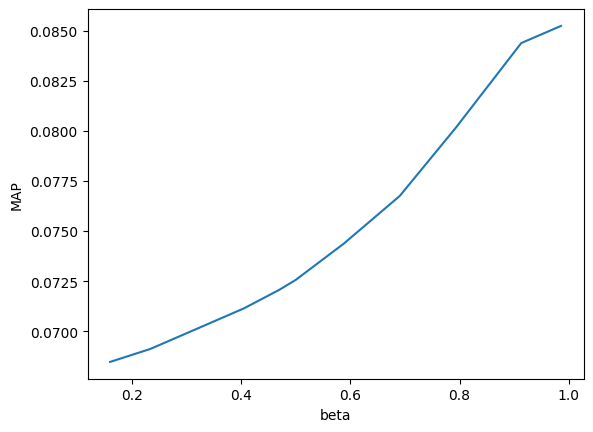

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["beta"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('beta')
pyplot.show()

In [ ]:
best_beta_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_beta_value

beta    0.985839
MAP     0.085235
Name: 1, dtype: object